<a href="https://colab.research.google.com/github/danlingzhou16/stat390/blob/Danling/Danling_390_lstm_rvsd110923.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
# libararies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
from keras.layers import LSTM, Dense, Input
from keras.models import Sequential
from keras import Model
from keras.optimizers import Adam
import time as time
warnings.filterwarnings("ignore")

In [61]:
train = pd.read_csv('train_final.csv', parse_dates = ['date'])
test = pd.read_csv('test_final.csv', parse_dates = ['date'])

In [62]:
# inspired by prophet, I am adding holidays as one-hot encoded variables
from prophet.make_holidays import make_holidays_df
us_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='US')
us_holidays['country_code'] ='US'
lu_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='LU')
lu_holidays['country_code'] ='LU'
ie_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='IE')
ie_holidays['country_code'] ='IE'
no_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='NO')
no_holidays['country_code'] = 'NO'
ch_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='CH')
ch_holidays['country_code'] = 'CH'
sg_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='SG')
sg_holidays['country_code'] = 'SG'
# qa_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='QA') Qatar is not supported
is_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='IS')
is_holidays['country_code'] = 'IS'
dk_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='DK')
dk_holidays['country_code'] = 'DK'
au_holidays = make_holidays_df(year_list=[2020 + i for i in range(3)], country='AU')
au_holidays['country_code'] = 'AU'

holidays = pd.concat([us_holidays, lu_holidays, ie_holidays, no_holidays, ch_holidays, sg_holidays, is_holidays, dk_holidays, au_holidays])

# Honestly I don't really care if what holiday it is, since there are so many in different countries
# however, I want to know if a specific day is a holiday or not.

holidays.holiday = 1

train_with_holiday = train.merge(holidays, how = 'left', left_on = ['date', 'country_code'], right_on = ['ds', 'country_code'])
train_with_holiday['holiday'].fillna(0, inplace = True)
test_with_holiday = test.merge(holidays, how = 'left', left_on = ['date', 'country_code'], right_on = ['ds', 'country_code'])
test_with_holiday['holiday'].fillna(0, inplace = True)

In [63]:
# drop useless columns
train_lstm = train_with_holiday.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0', 'day_name', 'new_confirmed_mean1', 'new_confirmed_max1', 'new_confirmed_min1', 'ds', 'country_code','new_confirmed_std1'])
test_lstm = test_with_holiday.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0', 'day_name', 'new_confirmed_mean1', 'new_confirmed_max1', 'new_confirmed_min1', 'ds', 'country_code','new_confirmed_std1'])

In [64]:
train_lstm.head()

,date,location_key_x,new_deceased,cumulative_deceased,population,population_male,population_female,latitude,longitude,area_sq_km,...,new_confirmed_min7,day_of_week,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,holiday
0,2020-01-22,US_AK,0.0,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,...,NaN,2,1,1,2020,22,22,4,Winter,0.0
1,2020-01-23,US_AK,0.0,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,...,NaN,3,1,1,2020,23,23,4,Winter,0.0
2,2020-01-24,US_AK,0.0,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,...,NaN,4,1,1,2020,24,24,4,Winter,0.0
3,2020-01-25,US_AK,0.0,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,...,NaN,5,1,1,2020,25,25,4,Winter,0.0
4,2020-01-26,US_AK,0.0,0.0,733391.0,424916.0,391925.0,64.0,-150.0,1717856.0,...,NaN,6,1,1,2020,26,26,4,Winter,0.0


In [65]:
# one-hot encoding

# day of the week -- turns out there is a day_of_week column that has already been encoded
# however, Mon-Sun is from 0-6 and I want it to be 1-7
train_lstm['day_of_week']= train_lstm['day_of_week'] + 1
test_lstm['day_of_week']= test_lstm['day_of_week'] + 1


# season
season_train = pd.get_dummies(train_lstm['season'],drop_first=True)
season_test = pd.get_dummies(test_lstm['season'],drop_first=True)


train_lstm = pd.concat([train_lstm, season_train], axis = 1).drop(columns = ['season'])
test_lstm = pd.concat([test_lstm, season_test], axis = 1).drop(columns = ['season'])

In [66]:
# drop addtional rows

# Since I am modeling based on reagion, I don't need any information that is
# constant within a region.
for col in train_lstm.loc[:, train_lstm.nunique() <= 103].columns:
  print(col)

location_key_x
population
population_male
population_female
latitude
longitude
area_sq_km
life_expectancy
aggregation_level
gdp_usd
gdp_per_capita_usd
AG.LND.AGRI.K2
AG.LND.AGRI.ZS
AG.LND.ARBL.HA
AG.LND.ARBL.HA.PC
AG.LND.ARBL.ZS
AG.LND.CROP.ZS
AG.LND.FRST.K2
AG.LND.FRST.ZS
AG.LND.TOTL.K2
AG.PRD.CROP.XD
AG.PRD.FOOD.XD
AG.PRD.LVSK.XD
AG.SRF.TOTL.K2
BX.KLT.DINV.CD.WD
EG.ELC.ACCS.RU.ZS
EG.ELC.ACCS.UR.ZS
EG.ELC.ACCS.ZS
EG.ELC.RNEW.ZS
EG.FEC.RNEW.ZS
EN.ATM.CO2E.GF.KT
EN.ATM.CO2E.GF.ZS
EN.ATM.CO2E.KT
EN.ATM.CO2E.LF.KT
EN.ATM.CO2E.LF.ZS
EN.ATM.CO2E.PC
EN.ATM.CO2E.SF.KT
EN.ATM.CO2E.SF.ZS
EN.ATM.PM25.MC.M3
EN.ATM.PM25.MC.T1.ZS
EN.ATM.PM25.MC.T2.ZS
EN.ATM.PM25.MC.T3.ZS
EN.ATM.PM25.MC.ZS
EN.BIR.THRD.NO
EN.FSH.THRD.NO
EN.HPT.THRD.NO
EN.MAM.THRD.NO
EN.POP.DNST
ER.FSH.CAPT.MT
ER.FSH.PROD.MT
ER.LND.PTLD.ZS
ER.PTD.TOTL.ZS
IP.JRN.ARTC.SC
IT.CEL.SETS
IT.CEL.SETS.P2
IT.MLT.MAIN
IT.MLT.MAIN.P2
IT.NET.BBND
IT.NET.BBND.P2
IT.NET.SECR
IT.NET.SECR.P6
IT.NET.USER.ZS
NV.IND.TOTL.CN
NV.IND.TOTL.ZS
NY.ADJ.AEDU.GN.

In [67]:
# select columns of interest only
col_to_keep = ['location_key_x', 'day_of_week', 'quarter', 'month', 'year','dayofmonth','weekofyear','Spring','Summer','Winter','holiday']
addtional_col = train_lstm.loc[:, train_lstm.nunique() > 103].columns.to_list()
for col in addtional_col:
  col_to_keep.append(col)

train_sel = train_lstm[col_to_keep]
test_sel = test_lstm[col_to_keep]

# put zeros to missing lagging features
train_sel.fillna(0, inplace = True)
test_sel.fillna(0, inplace = True)

In [9]:
train_date = train_sel.date
test_date = test_sel.date
train_no_date = train_sel.drop(columns = 'date')
test_no_date = test_sel.drop(columns = 'date')

In [10]:
data = pd.concat([train_no_date, test_no_date])
date_all = pd.concat([train_date, test_date])

Select out location of interest: US_AK

In [11]:
AK_date = date_all.loc[data.location_key_x == 'US_AK']
AK_data = data.loc[data.location_key_x == 'US_AK'].drop(columns = ['location_key_x']).astype(float)
AK_data.index = AK_date

Scale the dataset

In [12]:
scaler = StandardScaler()
AK_scaled = pd.DataFrame(data = scaler.fit_transform(AK_data), index = AK_data.index, columns = AK_data.columns)
AK_scaled['new_confirmed'] = AK_data['new_confirmed']

In [13]:
AK_scaled.loc['2021-12-31',:]

day_of_week                              0.500777
quarter                                  1.517565
month                                    1.795535
year                                     0.112316
dayofmonth                               1.736340
weekofyear                               1.884718
Spring                                  -0.632914
Summer                                  -0.632914
Winter                                   1.851109
holiday                                  5.681185
new_deceased                             0.283964
cumulative_deceased                      1.073160
mobility_workplaces                     -3.397362
new_persons_fully_vaccinated            -0.399262
cumulative_persons_fully_vaccinated      0.972655
new_confirmed                          277.000000
new_confirmed_lag1                       1.208060
new_confirmed_lag3                       0.437101
new_confirmed_lag7                      -0.428298
new_confirmed_mean3                      0.636360


In [14]:
def make_series(data):
    series=[]
    for i in range(14, len(data)+1):
        subdf=data[(i-14):i]
        series.append((data.index[i-1], data['new_confirmed'].values[i-1], subdf.drop('new_confirmed', axis=1).values))
    return series
series=make_series(AK_scaled)
print(series[0][0],series[0][1].shape,series[0][2].shape)
AK_train = series[:(AK_scaled.loc[AK_scaled.index < '2022-01-01'].shape[0]-13)]
AK_test = series[(AK_scaled.loc[AK_scaled.index < '2022-01-01'].shape[0]-13):]

2020-02-04 00:00:00 () (14, 27)


Training

In [15]:
learning_rate = 0.02
batch_size = 32 # how many data points do I go through
epochs = 200 # how many times I run through my whole dataset
sequence_length =14 # use the past 7 days to predict today

In [16]:
inputs = Input(shape=(14,27))
lstm_out = LSTM(32)(inputs)
outputs = Dense(1)(lstm_out)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 27)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                7680      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 7713 (30.13 KB)
Trainable params: 7713 (30.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
x=np.array([x[2].reshape(14,27) for x in AK_train])
y=np.array([x[1] for x in AK_train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(694, 14, 27)
(694,)
Epoch 1/200
22/22 [==============================] - 2s 5ms/step - loss: 114631.6328
Epoch 2/200
22/22 [==============================] - 0s 4ms/step - loss: 107968.3438
Epoch 3/200
22/22 [==============================] - 0s 4ms/step - loss: 102461.5312
Epoch 4/200
22/22 [==============================] - 0s 4ms/step - loss: 97639.7266
Epoch 5/200
22/22 [==============================] - 0s 4ms/step - loss: 93342.7109
Epoch 6/200
22/22 [==============================] - 0s 4ms/step - loss: 89439.5000
Epoch 7/200
22/22 [==============================] - 0s 4ms/step - loss: 85345.7266
Epoch 8/200
22/22 [==============================] - 0s 4ms/step - loss: 81302.5703
Epoch 9/200
22/22 [==============================] - 0s 4ms/step - loss: 77708.2500
Epoch 10/200
22/22 [==============================] - 0s 4ms/step - loss: 74494.7734
Epoch 11/200
22/22 [==============================] - 0s 4ms/step - loss: 71903.6953
Epoch 12/200
22/22 [==============================

In [18]:
AK_train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in AK_train])
AK_test_pred = pd.DataFrame(model.predict(np.array([x[2].reshape(14,27) for x in AK_test])), columns=['yhat'], index=[x[0] for x in AK_test ])

9/9 [==============================] - 0s 2ms/step


In [19]:
AK_test_pred

,yhat
2022-01-01,350.654846
2022-01-02,446.923920
2022-01-03,753.426514
2022-01-04,557.765137
2022-01-05,798.345947
...,...
2022-09-11,46.721428
2022-09-12,37.907108
2022-09-13,58.206024
2022-09-14,369.853668


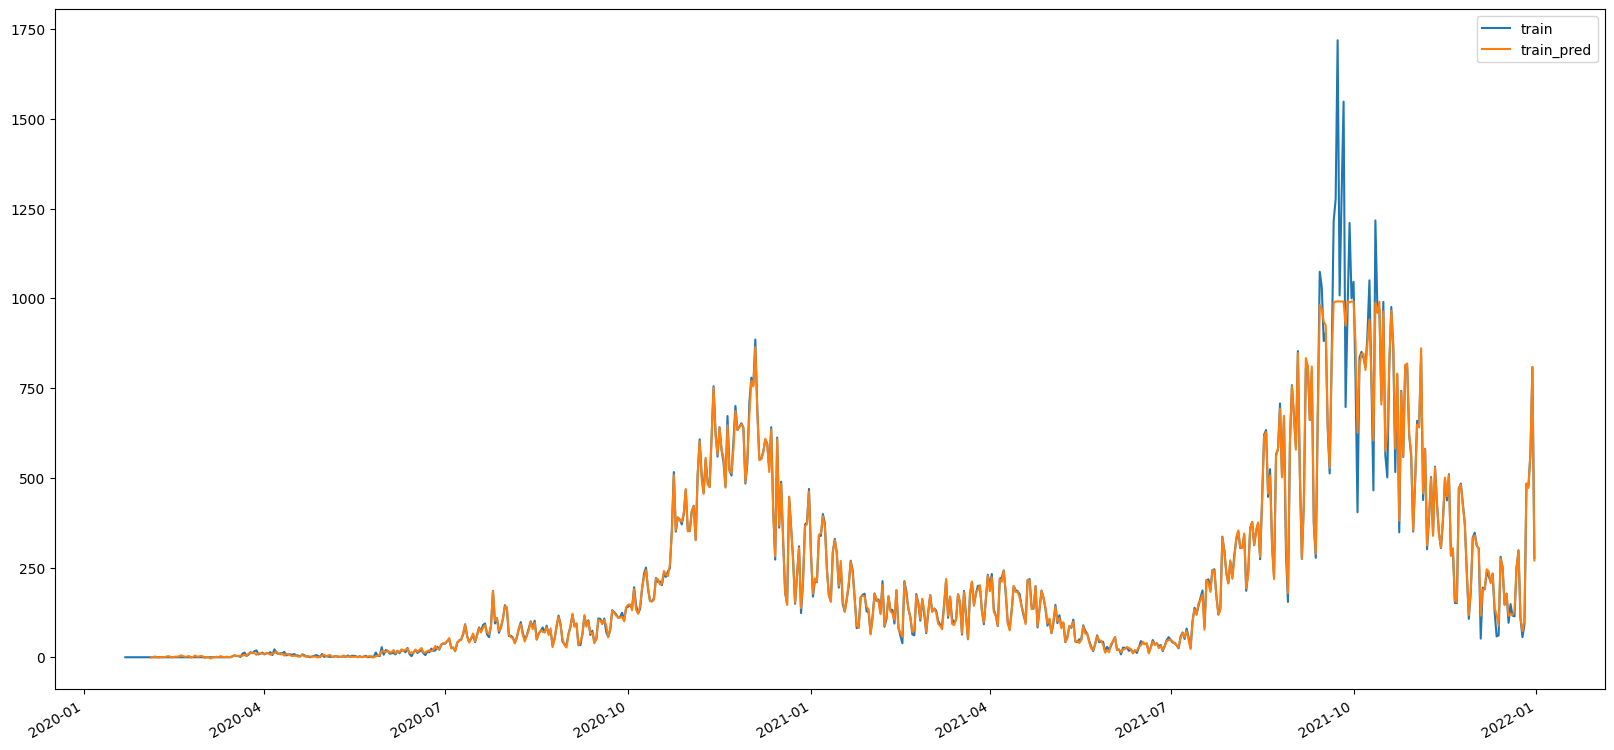

In [20]:
# plotting the training data
y_train_real = train.loc[train.location_key_x == 'US_AK', 'new_confirmed']
y_train_real.index = train.loc[train.location_key_x == 'US_AK', 'date']
pd.concat([y_train_real, AK_train_pred['yhat']], axis=1).plot(figsize=(20,10))
plt.legend(['train', 'train_pred'])

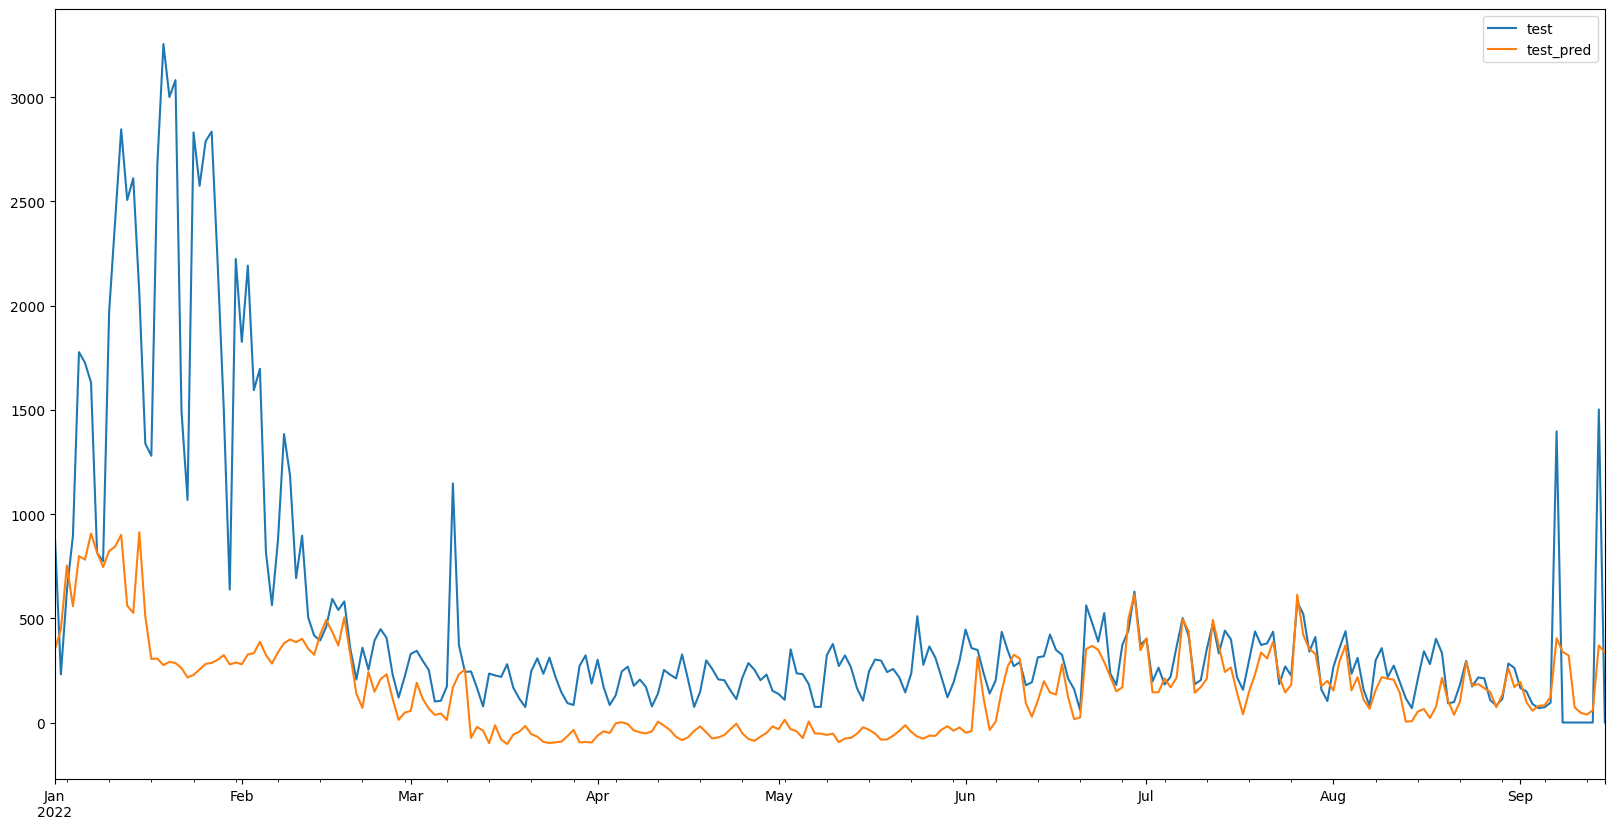

In [21]:
# plottting the testing data
y_test_real = test.loc[test.location_key_x == 'US_AK', 'new_confirmed']
y_test_real.index = test.loc[test.location_key_x == 'US_AK', 'date']
pd.concat([y_test_real, AK_test_pred['yhat']], axis=1).plot(figsize=(20,10))
plt.legend(['test', 'test_pred'])

In [24]:
print("the rmse on the training data is ", mean_squared_error(y_train_real[13:], AK_train_pred['yhat'], squared = False))
print("the rmse on the testing data is ", mean_squared_error(y_test_real, AK_test_pred['yhat'], squared = False))

the rmse on the training data is  44.59526888505613
the rmse on the testing data is  657.3934185595238


A bit overfitting. Cannot grab the pattern well. Lets tune this a bit.

In [ ]:
import itertools

# initialize combinations to test
learning_rate = [0.01, 0.02, 0.05]
epochs = [100, 200, 300]
batch_size =[16, 32, 64]
comb = list(itertools.product(learning_rate, epochs, batch_size))
comb

In [ ]:
rmse_list = []
order_list = []
x=np.array([x[2].reshape(14,27) for x in AK_train])
y=np.array([x[1] for x in AK_train])
start_time = time.time()
for com in comb:
    learning_rate = com[0]
    epochs = com[1]
    batch_size = com[2]
    # initialize model
    inputs = Input(shape=(14,27))
    lstm_out = LSTM(32)(inputs)
    outputs = Dense(1)(lstm_out)
    model_tune = Model(inputs=inputs, outputs=outputs)
    model_tune.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
    history = model_tune.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)
    AK_train_pred_tuned=pd.DataFrame(model_tune.predict(x), columns=['yhat'], index=[x[0] for x in AK_train])
    rmse = mean_squared_error(y_train_real[13:], AK_train_pred_tuned['yhat'], squared = False)
    rmse_list.append(rmse)
    order_list.append(com)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

In [28]:
results = pd.DataFrame(index = order_list, data = rmse_list, columns = ['rmse'])
results.reset_index(inplace = True)
results.sort_values(by = 'rmse', ascending = True).iloc[0,0]

(0.01, 300, 16)

In [30]:
results.sort_values(by = 'rmse', ascending = True)

,index,rmse
6,"(0.01, 300, 16)",27.982227
15,"(0.02, 300, 16)",28.301500
12,"(0.02, 200, 16)",32.204582
25,"(0.05, 300, 32)",32.913075
16,"(0.02, 300, 32)",33.493212
26,"(0.05, 300, 64)",37.123251
24,"(0.05, 300, 16)",37.424341
3,"(0.01, 200, 16)",38.584357
22,"(0.05, 200, 32)",40.993440
13,"(0.02, 200, 32)",45.523365


In [31]:
# tuned model
learning_rate = 0.01
batch_size = 16 # how many data points do I go through
epochs = 300 # how many times I run through my whole dataset
sequence_length =14 # use the past 14 days to predict today
inputs = Input(shape=(14,27))
lstm_out = LSTM(32)(inputs)
outputs = Dense(1)(lstm_out)
model2 = Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
x=np.array([x[2].reshape(14,27) for x in AK_train])
y=np.array([x[1] for x in AK_train])
print(x.shape)
print(y.shape)
history2 = model2.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)


(694, 14, 27)
(694,)
Epoch 1/300
44/44 [==============================] - 2s 4ms/step - loss: 114498.3047
Epoch 2/300
44/44 [==============================] - 0s 4ms/step - loss: 107529.1328
Epoch 3/300
44/44 [==============================] - 0s 4ms/step - loss: 102107.7812
Epoch 4/300
44/44 [==============================] - 0s 4ms/step - loss: 97085.3125
Epoch 5/300
44/44 [==============================] - 0s 4ms/step - loss: 92473.8828
Epoch 6/300
44/44 [==============================] - 0s 4ms/step - loss: 88486.8750
Epoch 7/300
44/44 [==============================] - 0s 4ms/step - loss: 84803.9297
Epoch 8/300
44/44 [==============================] - 0s 4ms/step - loss: 81284.6797
Epoch 9/300
44/44 [==============================] - 0s 4ms/step - loss: 77901.7734
Epoch 10/300
44/44 [==============================] - 0s 4ms/step - loss: 74830.5781
Epoch 11/300
44/44 [==============================] - 0s 4ms/step - loss: 71938.8750
Epoch 12/300
44/44 [==============================

In [32]:
AK_train_pred2=pd.DataFrame(model2.predict(x), columns=['yhat'], index=[x[0] for x in AK_train])
AK_test_pred2 = pd.DataFrame(model2.predict(np.array([x[2].reshape(14,27) for x in AK_test])), columns=['yhat'], index=[x[0] for x in AK_test ])

9/9 [==============================] - 0s 2ms/step


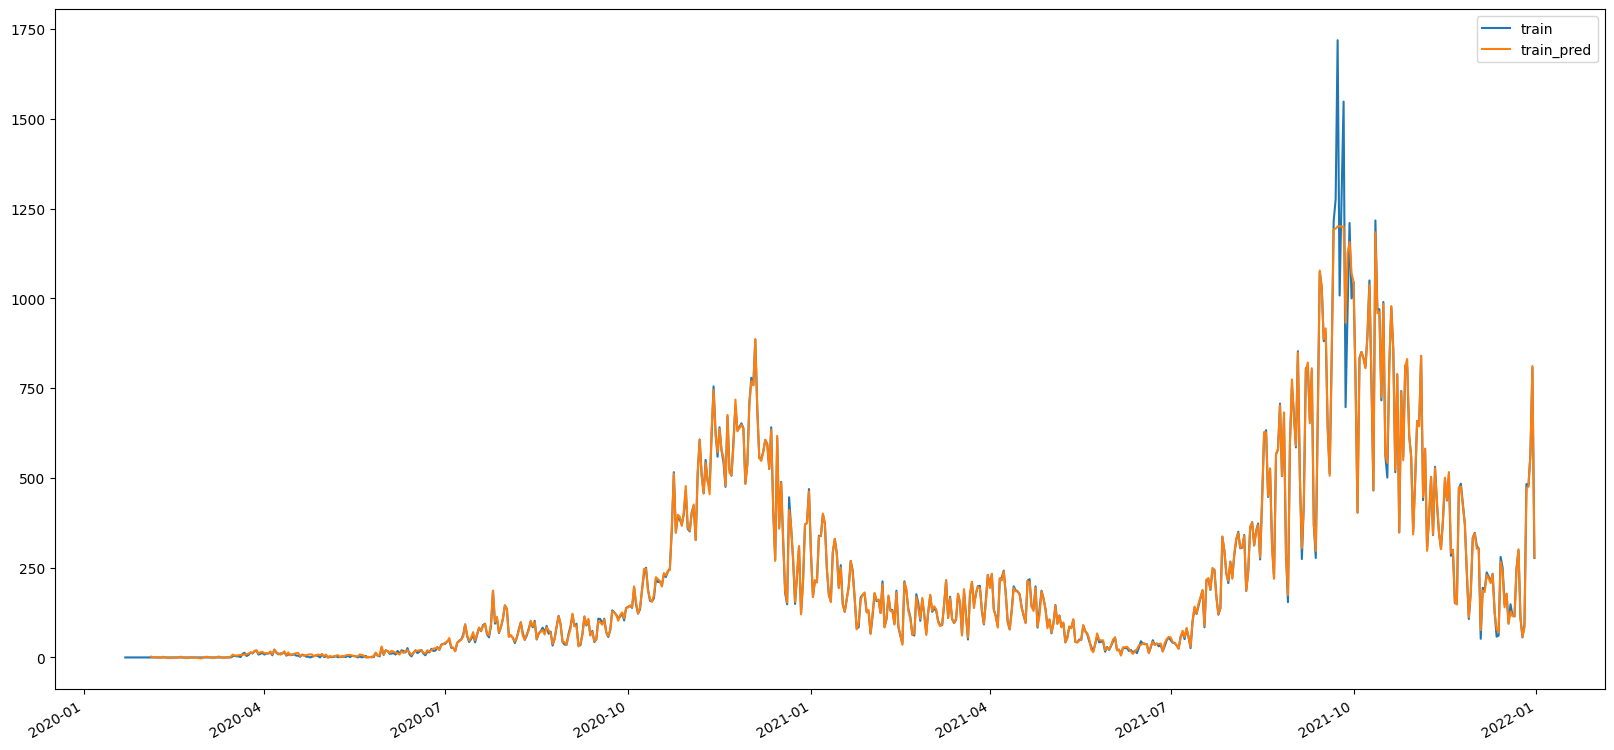

In [33]:
# plotting the training data

y_train_real = train.loc[train.location_key_x == 'US_AK', 'new_confirmed']
y_train_real.index = train.loc[train.location_key_x == 'US_AK', 'date']
pd.concat([y_train_real, AK_train_pred2['yhat']], axis=1).plot(figsize=(20,10))
plt.legend(['train', 'train_pred'])

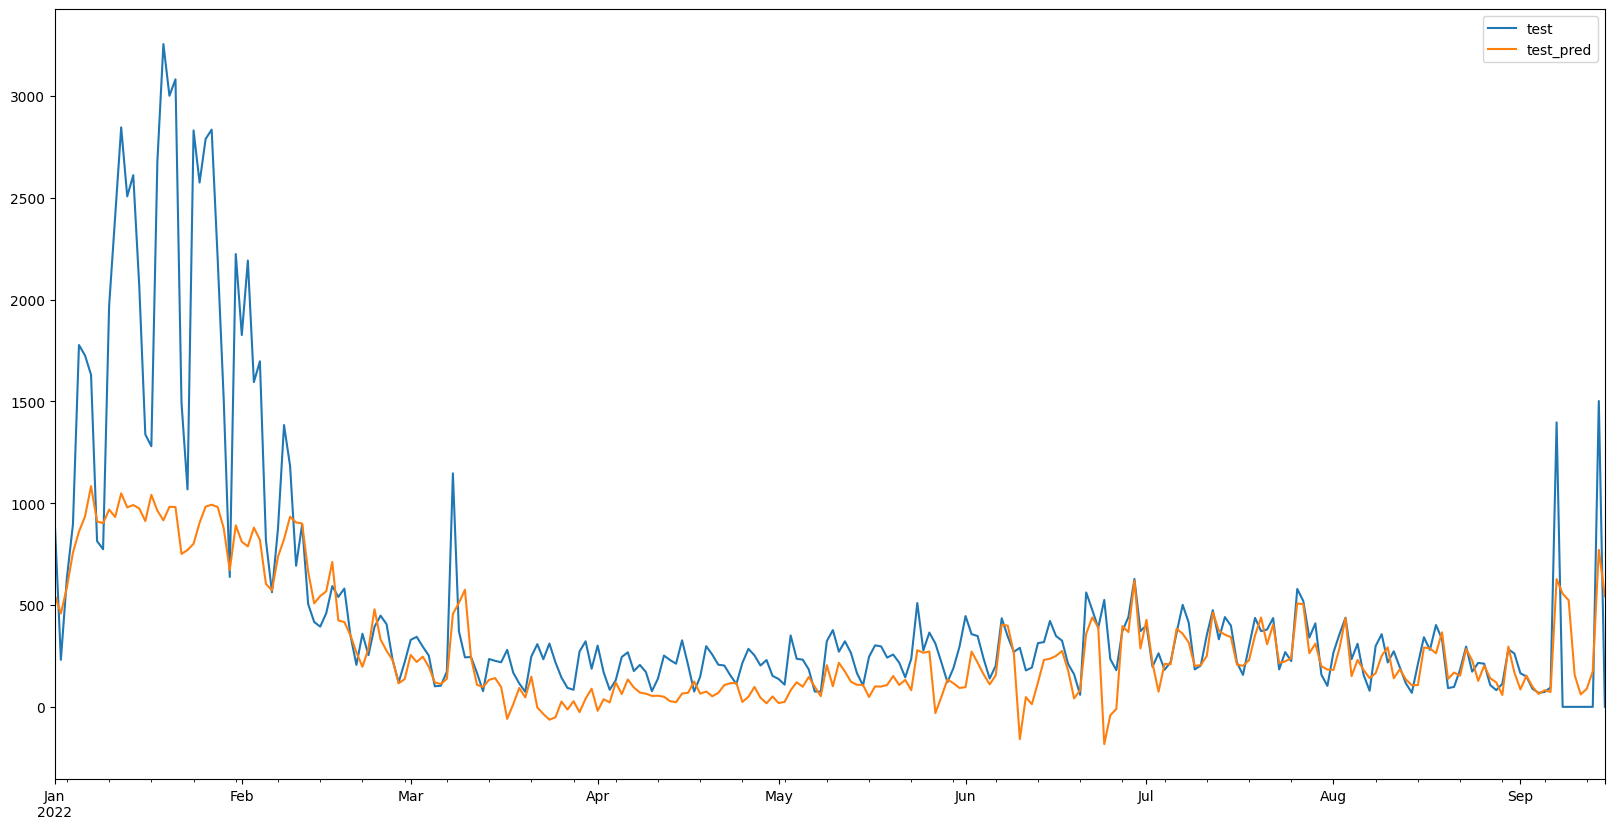

In [34]:
# plottting the testing data
y_test_real = test.loc[test.location_key_x == 'US_AK', 'new_confirmed']
y_test_real.index = test.loc[test.location_key_x == 'US_AK', 'date']
pd.concat([y_test_real, AK_test_pred2['yhat']], axis=1).plot(figsize=(20,10))
plt.legend(['test', 'test_pred'])

In [36]:
print("the rmse on the training data is ", mean_squared_error(y_train_real[13:], AK_train_pred2['yhat'], squared = False))
print("the rmse on the testing data is ", mean_squared_error(y_test_real, AK_test_pred2['yhat'], squared = False))

the rmse on the training data is  28.202451659682282
the rmse on the testing data is  485.9434839121061


The performance on the testing data is better, but still not able to catch the first peak at the start of 2022.

Apply to the whole dataset.

In [37]:
# make series define again
def make_series(data):
    series=[]
    for i in range(14, len(data)+1):
        subdf=data[(i-14):i]
        series.append((data.index[i-1], data['new_confirmed'].values[i-1], subdf.drop('new_confirmed', axis=1).values))
    return series

In [38]:
# making a pred_train and pred_test dataset
train_pred = train_lstm[['location_key_x','date','new_confirmed']]
train_pred.new_confirmed = None
train_pred.columns = ['location_key_x','date','predicted_new_confirmed']

test_pred = test_lstm[['location_key_x','date','new_confirmed']]
test_pred.new_confirmed = None
test_pred.columns = ['location_key_x','date','predicted_new_confirmed']


In [39]:
test_pred

,location_key_x,date,predicted_new_confirmed
0,US_AK,2022-01-01,None
1,US_AK,2022-01-02,None
2,US_AK,2022-01-03,None
3,US_AK,2022-01-04,None
4,US_AK,2022-01-05,None
...,...,...,...
26217,AU_WA,2022-09-14,None
26218,AU_WA,2022-09-15,None
26219,AU_WA,2022-09-16,None
26220,AU_WA,2022-09-23,None


In [ ]:
loc_list = list(train_lstm.location_key_x.unique())
start_time = time.time()
for loc in loc_list:
  # to locate the slice of the dataset
  interest_date = date_all.loc[data.location_key_x == loc]
  interest_data = data.loc[data.location_key_x == loc].drop(columns = ['location_key_x']).astype(float)
  interest_data.index = interest_date

  # scale the data and make a series to feed to the model
  scaler = StandardScaler()
  int_scaled = pd.DataFrame(data = scaler.fit_transform(interest_data), index = interest_data.index, columns = interest_data.columns)
  int_scaled['new_confirmed'] = interest_data['new_confirmed']
  series=make_series(int_scaled)
  interest_train = series[:(int_scaled.loc[int_scaled.index < '2022-01-01'].shape[0]-13)]
  interest_test = series[(int_scaled.loc[int_scaled.index < '2022-01-01'].shape[0])-13:]
  # fit the model
  learning_rate = 0.01
  batch_size = 16
  epochs = 300
  sequence_length =14 # use the past 14 days to predict today
  inputs = Input(shape=(14,27))
  lstm_out = LSTM(32)(inputs)
  outputs = Dense(1)(lstm_out)
  model3 = Model(inputs=inputs, outputs=outputs)
  model3.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
  x=np.array([x[2].reshape(14,27) for x in interest_train])
  y=np.array([x[1] for x in interest_train])
  history3 = model3.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,)
  # predict the train and test
  pred_for_train = pd.DataFrame(model3.predict(x), columns=['yhat'], index=[x[0] for x in interest_train])
  pred_for_test = pd.DataFrame(model3.predict(np.array([x[2].reshape(14,27) for x in interest_test])), columns=['yhat'], index=[x[0] for x in interest_test])
  pred_for_train.reset_index(names = 'date', inplace = True)
  pred_for_test.reset_index(names = 'date', inplace = True)
  for date in pred_for_train.date:
    train_pred.loc[(train_pred.location_key_x == loc) & (train_pred.date == date), 'predicted_new_confirmed'] = float(pred_for_train.loc[pred_for_train.date == date, 'yhat'])
  for date in pred_for_test.date:
    test_pred.loc[(test_pred.location_key_x == loc) & (test_pred.date == date), 'predicted_new_confirmed'] = float(pred_for_test.loc[pred_for_test.date == date, 'yhat'])
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

The missing first 14 days: since it was the start of the pandemic, I would just fill it as  0

In [88]:
train_pred.fillna(0, inplace = True)

In [89]:
print("the rmse on the training data is ", mean_squared_error(train['new_confirmed'], train_pred['predicted_new_confirmed'], squared = False))
print("the rmse on the testing data is ", mean_squared_error(test.new_confirmed, test_pred['predicted_new_confirmed'], squared = False))

the rmse on the training data is  1998.6150002607358
the rmse on the testing data is  7065.159741204752
